In [7]:
import os
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
from multiprocessing import Pool
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
from collections import Counter
from copy import deepcopy
from cdo import Cdo
cdo = Cdo()

# Add directory to path
import sys
sys.path.append('/vortexfs1/home/kcarr/summer-project-2020/') 
import utils
from utils import stack_month_and_year, unstack_month_and_year, get_proj_xr
from preprocess import remove_season, get_trend_fast

scratch_dir = '/vortexfs1/scratch/kcarr'

cdo


# Read in data and trim lon/lat range

In [1]:
# class file_processor():
#     def __init__(self, var_name, lon_range, lat_range):
#         self.var_name = var_name
#         self.lon_range = lon_range
#         self.lat_range = lat_range
#         return
    
#     def trim_file(self, x):
#         '''Function trims file according to lon/lat range'''
#         f_in, f_out = x
#         lon1, lon2 = self.lon_range
#         lat1, lat2 = self.lat_range
#         cdo.sellonlatbox(f'{lon1},{lon2},{lat1},{lat2}', 
#                          input = f'-selvar,{self.var_name} '+ f_in, 
#                          output = f_out)
#         return

# flut_proc = file_processor(var_name='FLUT', lon_range=(0,360), lat_range=(-15,15))
# u200_proc = file_processor(var_name='U200', lon_range=(0,360), lat_range=(-15,15))
# u850_proc = file_processor(var_name='U850', lon_range=(0,360), lat_range=(-15,15))
# prect_proc = file_processor(var_name='PRECT', lon_range=(0,360), lat_range=(-15,15))
# sst_proc = file_processor(var_name='SST', lon_range=(190,240), lat_range=(-5,5))

def get_files(var_name):
    '''Get input and output file names for given variable'''
    files = sorted(glob.glob(os.path.join(scratch_dir, f'*{var_name}*.nc')))
    files = [(f, f'{scratch_dir}/{var_name}_{f[53:56]}.nc') for f in files]
    return files        

flut_files = get_files('FLUT')
u200_files = get_files('U200')
u850_files = get_files('U850')
prect_files = get_files('PRECT')
sst_files = get_files('SST')
lf_file = get_files('LANDFRAC')[0][0]

### Regrid precipitation data
def regrid_sst(infile, outfile, res):
    '''Function regrids data in given model folder to global lonlat resolution given by res'''
    try:
        cdo.remapbil(res, input=f'-selname,SST {infile}', output=outfile)
    except CDOException:
        print(f'Cannot remap')
    return

out_file = os.path.join(scratch_dir, 'sst_regrid.nc')
# regrid_sst(infile=sst_files[-1][0], outfile=out_file, res='r288x192')

sst = xr.open_dataset(out_file).SST.squeeze('z_t', drop=True)
sst = sst.sel(lat=slice(-5,5), lon=slice(190,240))

olr = xr.open_dataset(flut_files[-1][0]).FLUT
olr = olr.sel(lat=slice(-15,15))

u200 = xr.open_dataset(u200_files[-1][0]).U200
u200 = u200.sel(lat=slice(-15,15))

u850 = xr.open_dataset(u850_files[-1][0]).U850
u850 = u850.sel(lat=slice(-15,15))

prect = xr.open_dataset(prect_files[-1][0]).PRECT
prect = prect.sel(lat = slice(25, 50), lon=slice(230,300))

# make sure dates align
u200 = u200.sel(time=slice('1920-04-02',None))
u850 = u850.sel(time=slice('1920-04-02',None))
olr = olr.sel(time=slice('1920-04-02',None))

##### Mask ocean for precipitation data ######
# # # mask ocean in precip data
# lf = xr.open_dataset(lf_file).LANDFRAC.mean(dim='time')
# thresh=.3
# lfrac_binary = deepcopy(lf).sel(lon=slice(230,300), lat=slice(25,50))
# lfrac_binary.values[lfrac_binary.values>thresh]=1
# lfrac_binary.values[lfrac_binary.values<thresh]=np.nan
# lfrac_binary['lat'] = prect.lat # make sure latitudes are the same
# prect = prect * lfrac_binary

NameError: name 'glob' is not defined

# 1. Compute anomalies and detrend

Do (monthly) SST data first

In [58]:
# compute oceanic nino index (oni)
sst = sst - get_trend_fast(sst)
sst = remove_season(sst, standardize=False)[0]
oni = sst.mean(dim=['lon','lat']).rolling(time=3).mean()

# interpolate to daily
oni_daily = oni.interp(time=pd.date_range('1920-03-01', '2006-01-01', freq='D'))

# remove NaN values
oni_daily = oni_daily[~np.isnan(oni_daily)][:-1]

# remove leap days
oni_daily = oni_daily.sel(time=~((oni_daily.time.dt.month == 2) \
                                 & (oni_daily.time.dt.day==29)))
# make sure times are in the same format as prect
oni_daily['time'] = prect.time.sel(time=slice('1920-04-02', '2005-12-31'))
oni.to_netcdf(os.path.join(scratch_dir, 'oni.nc'))
oni_daily.to_netcdf(os.path.join(scratch_dir, 'oni_daily.nc'))

Next, daily data (u-wind, OLR, precipitation)

In [ ]:
# Function to detrend
def prep(x):
    '''Function removes trend and seasonal cycle from xarray variable'''
    y = x - get_trend_fast(x)
    y = y.groupby('time.month') - y.groupby('time.month').mean()
    return y

# # do each variable in parallel
# with Pool(4) as p:
#     r = p.map(prep, [olr, u200, u850, prect])

# # unpack results    
# olr, u200, u850, prect = r    

#### Checkpoint: save or load pre-processed data

In [2]:
##### save to files
# olr.to_netcdf(os.path.join(scratch_dir, 'olr_prep.nc'))
# u200.to_netcdf(os.path.join(scratch_dir, 'u200_prep.nc'))
# u850.to_netcdf(os.path.join(scratch_dir, 'u850_prep.nc'))
# prect.to_netcdf(os.path.join(scratch_dir, 'prect_prep.nc'))

##### Read in de-trended and de-seasonalized data
olr = xr.open_dataarray(os.path.join(scratch_dir, 'olr_prep.nc'))
u200 = xr.open_dataarray(os.path.join(scratch_dir, 'u200_prep.nc'))
u850 = xr.open_dataarray(os.path.join(scratch_dir, 'u850_prep.nc'))
prect = xr.open_dataarray(os.path.join(scratch_dir, 'prect_prep.nc'))
oni = xr.open_dataarray(os.path.join(scratch_dir, 'oni.nc'))
oni_daily = xr.open_dataarray(os.path.join(scratch_dir, 'oni_daily.nc'))

# 2. Remove ENSO variability and get running mean
Remove the variability associated with ENSO from the atmospheric data. Also get the 120 day rolling mean of the daily data.

In [3]:
######## remove linear relationship with ENSO #######
u200 = u200 - get_proj_xr(oni_daily, u200)
u850 = u850 - get_proj_xr(oni_daily, u850)
olr = olr - get_proj_xr(oni_daily, olr)

######## remove 120-day running mean #########
u200 = u200.isel(time=slice(119,None)) - \
        u200.rolling(time=120).mean().isel(time=slice(119,None))
u850 = u850.isel(time=slice(119,None)) - \
        u850.rolling(time=120).mean().isel(time=slice(119,None))
olr = olr.isel(time=slice(119,None)) - \
        olr.rolling(time=120).mean().isel(time=slice(119,None))

# 3. Average over latitudes, and normalize by variance

In [4]:
######## Take latitudinal mean, and normalize by variance ########
u200 = u200.mean(dim='lat')
u200 = u200 / u200.std()

u850 = u850.mean(dim='lat')
u850 = u850 / u850.std()

olr = olr.mean(dim='lat')
olr = olr / olr.std()

mjo_data = xr.concat([u200, u850, olr], 
                     dim=pd.Index(['u200','u850','olr'],name='variable'))
mjo_data = mjo_data.transpose('time',...)
mjo_data = mjo_data - mjo_data.mean(dim='time') # make sure centered at 0

## save to file
# mjo_data.to_netcdf(os.path.join(scratch_dir, 'mjo_data_prep.nc'))


# 4. Compute EOFs

In [3]:
### load in pre-processed MJO data ###
mjo_data = xr.open_dataarray(os.path.join(scratch_dir, 'mjo_data_prep.nc'))
eof_obj = Eof(mjo_data) #### EOF analysis to get MJO index

# Get 1st two principal components (used to identify MJO phase)
rmm = eof_obj.pcs(pcscaling=1, npcs=2)
rmm1 = rmm.sel(mode=0)
rmm2 = rmm.sel(mode=1)

# check reconstruction
res2 = np.einsum('ab,bcd->acd', eof_obj.pcs(pcscaling=1), eof_obj.eofs(eofscaling=2)).reshape(mjo_data.shape)
print(np.allclose(mjo_data, res2))

True


# 5. Get MJO phase based on EOFs

In [4]:
def get_mjo_phase(x, y):
    '''Function to get the phase of the MJO, based on first two PCs from Wheeler/Hendon index'''
    mag = np.sqrt(x**2 + y**2)
    if mag < 1: # only classify if magnitude is greater than 1
        return -1
    else:
        if x>=0:
            if y>=0:
                return 5. if np.abs(x)>=np.abs(y) else 6
            else:
                return 4 if np.abs(x)>=np.abs(y) else 3
        else:
            if y>=0:
                return 8 if np.abs(x)>=np.abs(y) else 7
            else:
                return 1 if np.abs(x)>=np.abs(y) else 2
            return
        return
    return

def get_mjo_phase_(data):
    '''Helper function: takes single argument, allowing us to pass it to np.apply_along_axis'''
    x,y = data
    return get_mjo_phase(x,y)

##### Determine the MJO phases ######
mjo_phase = np.nan * deepcopy(rmm1)
mjo_phase.values = np.apply_along_axis(func1d=get_mjo_phase_, 
                                       arr=np.stack([rmm1.values,rmm2.values],axis=1), axis=1)

# Plots

### Leading EOFs and explained variance

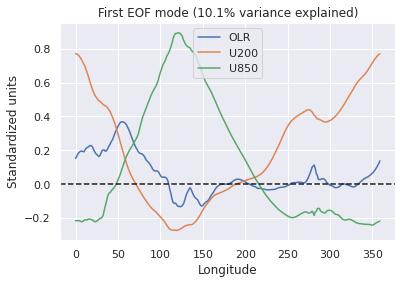

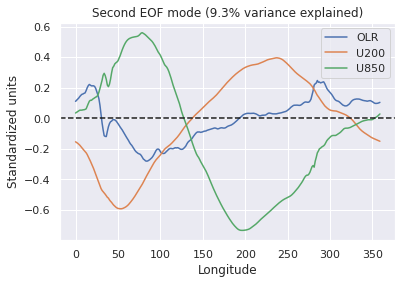

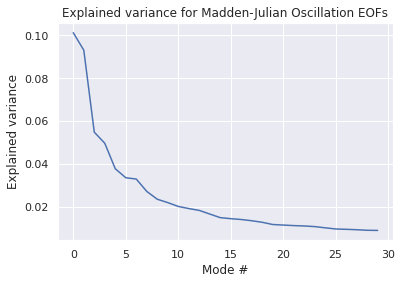

In [5]:
####### Plot the two dominant EOFs (corresponding to the RMM index)
s=2 # scaling to use for EOF plots

# First EOF
fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
v1 = eof_obj.varianceFraction(neigs=1).values.item()
ax.set_title(f'First EOF mode ({100*v1:.1f}% variance explained)')
ax.legend()
plt.show()

# Second EOF
fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().lon, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
v2 = eof_obj.varianceFraction(neigs=2).values[-1].item()
ax.set_title(f'Second EOF mode ({100*v2:.1f}% variance explained)')
ax.legend()
plt.show()

# Explained variance for EOFs
fig,ax=plt.subplots()
ax.plot(eof_obj.varianceFraction(neigs=30))
ax.set_ylabel('Explained variance')
ax.set_xlabel('Mode #')
ax.set_title('Explained variance for Madden-Julian Oscillation EOFs')
plt.show()

## MJO phase composites

#### OLR/U850 composite (DJF months)

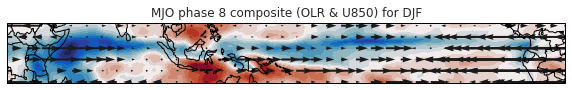

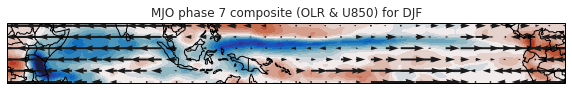

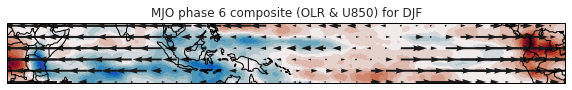

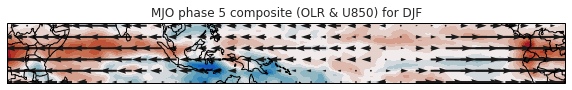

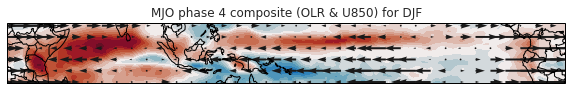

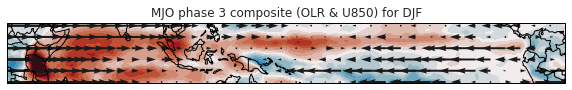

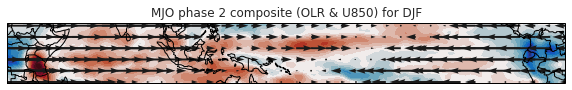

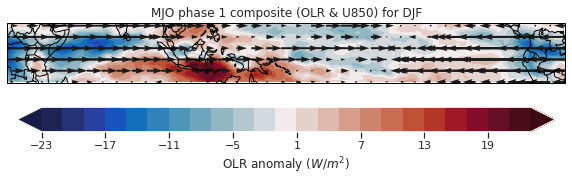

In [18]:
n=6 # plot every nth vector in the plots
for phase in np.arange(8,0,-1): # do for each of the 8 phases
# for phase in np.arange(1,9): # do for each of the 8 phases
    d = mjo_phase[mjo_phase==phase].time
    d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)] # get DJF months
    phase_composite = olr.sel(time=d).mean(dim='time') # get OLR composite
    wind_composite = u850.sel(time=d).mean(dim='time') # get wind composite (U850)
    
    fig, ax = utils.plot_setup(plot_range=[20,300,-15,15], central_lon=180, figsize=(10,3))
    ax.set_title(f'MJO phase {phase} composite (OLR & U850) for DJF')
    cp = ax.contourf(phase_composite.lon, phase_composite.lat, phase_composite, # plot OLR              
                    cmap='cmo.balance', extend='both', transform=ccrs.PlateCarree(),
                    levels=np.arange(-23,25,2))
    qv = ax.quiver(u850.lon.values[::n], # plot wind
                   u850.lat.values[::n],
                   wind_composite[::n,::n],
                   np.zeros_like(wind_composite.values)[::n,::n])
    if phase==1:
        cb = fig.colorbar(cp, orientation='horizontal', label=r'OLR anomaly ($W/m^2$)')
    plt.show()

#### OLR/U850 composite (all months)

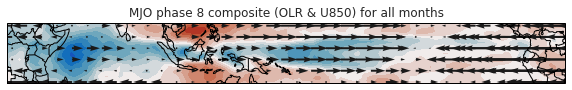

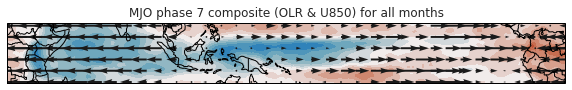

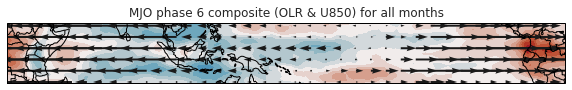

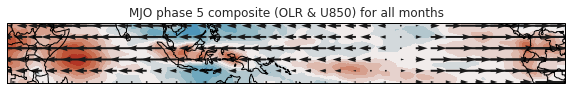

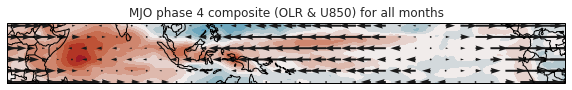

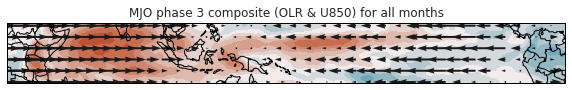

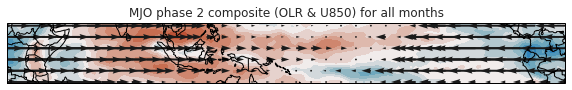

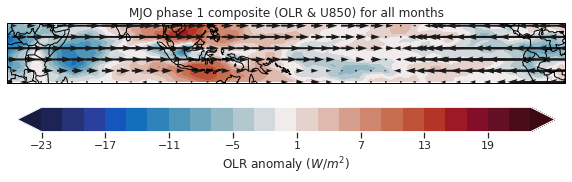

In [21]:
n=6 # plot every nth vector in the plots
for phase in np.arange(8,0,-1): # do for each of the 8 phases
# for phase in np.arange(1,9): # do for each of the 8 phases
    d = mjo_phase[mjo_phase==phase].time
#     d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)] # get DJF months
    phase_composite = olr.sel(time=d).mean(dim='time') # get OLR composite
    wind_composite = u850.sel(time=d).mean(dim='time') # get wind composite (U850)
    
    fig, ax = utils.plot_setup(plot_range=[20,300,-15,15], central_lon=180, figsize=(10,3))
    ax.set_title(f'MJO phase {phase} composite (OLR & U850) for all months')
    cp = ax.contourf(phase_composite.lon, phase_composite.lat, phase_composite, # plot OLR              
                    cmap='cmo.balance', extend='both', transform=ccrs.PlateCarree(),
                    levels=np.arange(-23,25,2))
    qv = ax.quiver(u850.lon.values[::n], # plot wind
                   u850.lat.values[::n],
                   wind_composite[::n,::n],
                   np.zeros_like(wind_composite.values)[::n,::n])
    if phase==1:
        cb = fig.colorbar(cp, orientation='horizontal', label=r'OLR anomaly ($W/m^2$)')
    plt.show()

### plot sample of MJO phase

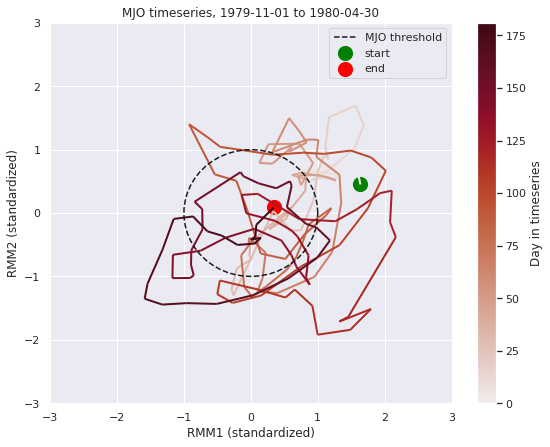

In [103]:
theta = np.linspace(0,2*np.pi)
x0 = np.cos(theta)
y0 = np.sin(theta)
year = 1979
d1 = f'{year}-11-01'
d2 = f'{year+1}-04-30'
x = rmm1.sel(time=slice(d1,d2))
y = rmm2.sel(time=slice(d1,d2))

fig,ax = plt.subplots(figsize=(9,7))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(x))
lc = LineCollection(segments, cmap='cmo.amp', norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)
line = ax.add_collection(lc)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.scatter(x[0],y[0],marker='o', s=200, label='start', color='green')
ax.scatter(x[-1],y[-1],marker='o', s=200, label='end', color='red')
ax.plot(x0,y0, linestyle='--', color='k', label='MJO threshold')
ax.set_xlabel('RMM1 (standardized)')
ax.set_ylabel('RMM2 (standardized)')
ax.set_title('MJO timeseries, 1979-11-01 to 1980-04-30')
ax.legend()
fig.colorbar(line, label='Day in timeseries')
plt.show()

### Distribution of MJO over months

In [19]:
phase_counts   = Counter(mjo_phase[mjo_phase>0].values)
monthly_counts = Counter(mjo_phase[mjo_phase>0].time.dt.month.values)

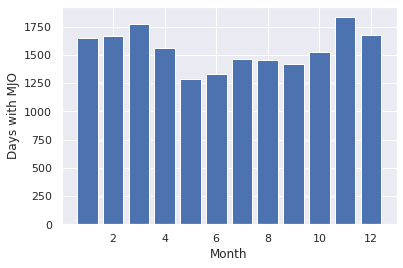

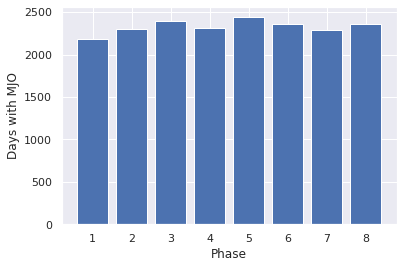

In [20]:
fig,ax = plt.subplots()
ax.bar(monthly_counts.keys(), monthly_counts.values())
ax.set_xlabel('Month')
ax.set_ylabel('Days with MJO')
plt.show()

fig,ax = plt.subplots()
ax.bar(phase_counts.keys(), phase_counts.values())
ax.set_xlabel('Phase')
ax.set_ylabel('Days with MJO')
plt.show()

### MJO composite for precipitation

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


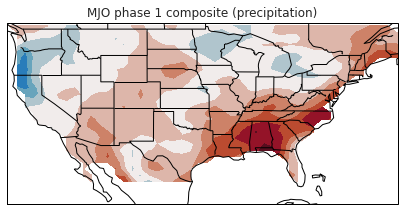

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


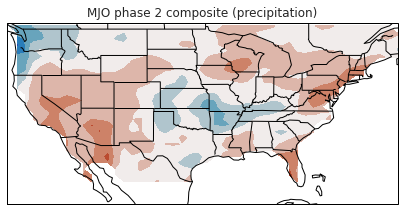

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


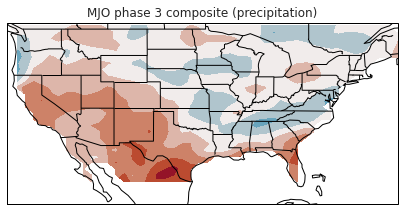

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


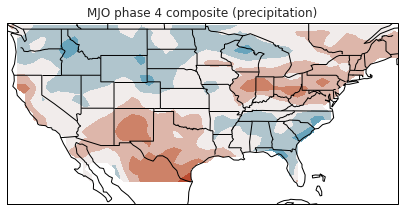

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


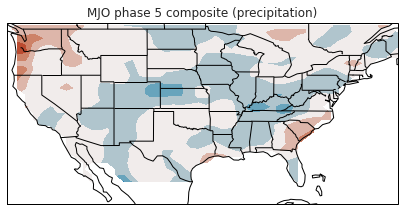

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


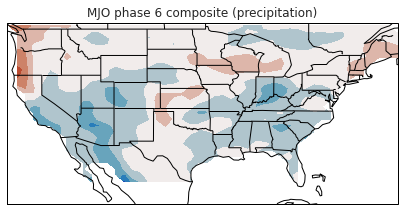

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


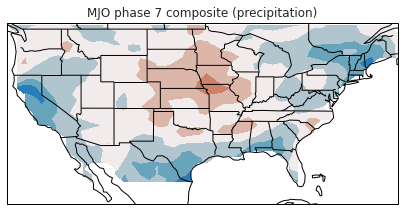

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


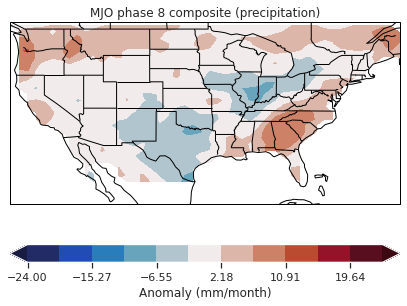

In [109]:
for phase in range(1,9):
    d = mjo_phase[mjo_phase==phase].time
#     d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)]
    phase_composite = prect.sel(time=d).mean(dim='time')
    
    fig,ax = utils.plot_setup()
    cp = ax.contourf(phase_composite.lon, phase_composite.lat, a*phase_composite, cmap='cmo.balance',
                    levels=np.linspace(-24,24,12), extend='both')
    if phase==8:
        cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
    ax.set_title(f'MJO phase {phase} composite (precipitation)')
    plt.show()

# Precipitation clustering / ENSO analysis

### Identify precipitation regions

In [9]:
print('clustering')
prect_ = prect.stack(posn=['lat','lon'])

idx = np.where(~np.isnan(prect_.isel(time=0)).values)[0]
vals = prect_.isel(posn=idx).values

from sklearn.cluster import KMeans
from copy import deepcopy

# Fit kmeans
model = KMeans(n_clusters=9)
model.fit(vals.T)

# Get labels
labels = np.nan*deepcopy(prect_.isel(time=0, drop=True))
labels[idx] = model.labels_
labels = labels.unstack()

k_vals = np.unique(labels.values)
k_vals = k_vals[~np.isnan(k_vals)]

cluster_mask = xr.concat([labels for _ in range(len(k_vals))], dim='cluster').assign_coords({'cluster':k_vals})
for i,c in enumerate(cluster_mask.cluster.values):
    cluster_mask.values[i,:] = 1. * cluster_mask.values[i,:]==c

cluster_mask.values[cluster_mask.values==0] = np.nan    

clustering


**Plot clusters**

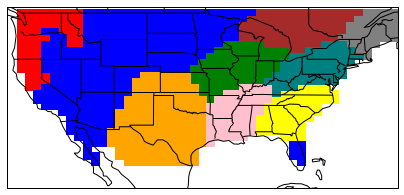

In [10]:
def plot_clusters(labels, colors, plot_range=[-125.25, -66, 22.5, 50]):
    '''Function plots clusters on map'''
    x,y = np.meshgrid(labels.lon.values, labels.lat.values)
    k_vals = np.unique(labels.values)
    k_vals = k_vals[~np.isnan(k_vals)]
    fig, ax = utils.plot_setup()
    for i, k in enumerate(k_vals):
        color = ListedColormap(colors[i])
        mask = (labels.values==k)*1.
        mask[mask==0] = np.nan
        ax.pcolormesh(x,y,mask, cmap=color)
    return fig, ax

colors = ['red','blue','green','orange','pink','yellow', 'brown', 'gray', 'teal']
fig, ax = plot_clusters(labels, colors = colors)

## Composite of El-Nino events

In [8]:
nino_days = oni_daily[oni_daily > oni_daily.std()].time
nina_days = oni_daily[oni_daily < -oni_daily.std()].time

In [9]:
nino_composite = prect.sel(time=nino_days).mean(dim='time')
nina_composite = prect.sel(time=nina_days).mean(dim='time')

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


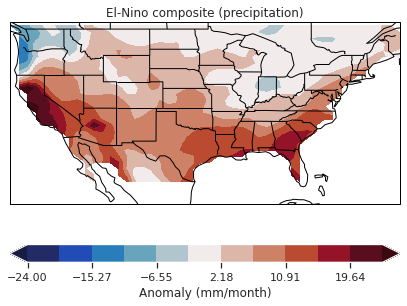

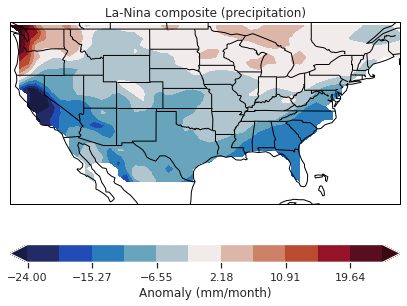

In [10]:
a = 1000*3600*24*365/12 # conversion factor from m/s to mm/month

fig,ax = utils.plot_setup()
cp = ax.contourf(nino_composite.lon, nino_composite.lat, a*nino_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'El-Nino composite (precipitation)')
plt.show()

fig,ax = utils.plot_setup()
cp = ax.contourf(nina_composite.lon, nina_composite.lat, a*nina_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'La-Nina composite (precipitation)')
plt.show()

#### ONI timeseries

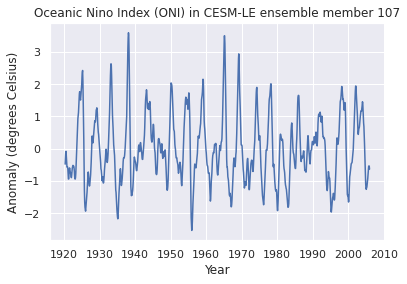

In [5]:
## plot ONI index
fig,ax = plt.subplots()
ax.plot(oni.time, oni)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('Oceanic Nino Index (ONI) in CESM-LE ensemble member 107')
plt.show()